In [1]:
import glob
import tqdm
import nltk
from nltk import word_tokenize
import spacy
import string
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import collections
import argparse
import os
import json
import time
import logging
import re
from collections import Counter
import string
punctuations = list(string.punctuation)
import warnings
warnings.simplefilter(action='ignore')#, category=FutureWarning)

In [2]:
def readFileNew_withTime(filename):
    '''
    This function is used to find out how much time a user would need to respond to a question
    input: transcript file name
    output: a list with timestamps within one transcript
    e.g. ['2019-03-31 12:32', '2019-03-31 12:32', ...]
    '''
    f = open(filename,"r")
    temp_list = []
    c = 0
    personName = ''
    botName = ''
    count = 0
    for i, line in enumerate(f):
        #print(line)
        c+=1
        if i==0:
            indBotNameSt = line.find(']')+1
            #first ":" appears in the timestamp
            indFirstCoBotName = line.find(':')
            indSecondCoBotName = indFirstCoBotName + line[indFirstCoBotName+1:].find(':') + 1
            botName = line[indBotNameSt:indSecondCoBotName].strip()
                
        elif not personName:            
            indPersonNameSt = line.find(']')+1
            indFirstCoPersonName = line.find(':')
            indSecondCoPersonName = indFirstCoPersonName + line[indFirstCoPersonName+1:].find(':') + 1
            tmpName = line[indPersonNameSt:indSecondCoPersonName].strip()
            if tmpName != botName:
                personName = tmpName
                    
        if line[1:3]=='20': #check if start with date
            if '{' not in line:
                indSentenceSt = line.find(']')+1
                temp_list.append(line[:indSentenceSt])
            else:
                indSentenceSt = line.find(']')+1
                if 'wording' in line:
                    temp_text = line[line.find(':wording')+8 : line.find(':qid')]
                    temp_list.append(line[:indSentenceSt])
                    #temp_list.append(botName+': single or multi'+str(count)+'ple choice Q')
                    count+=1
                else:
                    if botName not in line:
                        temp_list.append(line[:indSentenceSt])
            temp_list[-1] = temp_list[-1].rstrip('\n')
            
    return temp_list
def readFileNew(filename):
    '''
    input: transcript file name
    output: a list contains all the text
    e.g. ['Juji: Can you introduce yourself?', 'User: I love swimming', 'Juji: Thank you! Goodbye.']
    '''
    f = open(filename,"r")
    temp_list = []
    c = 0
    personName = ''
    botName = ''
    count = 0
    for i, line in enumerate(f):
        #print(line)
        c+=1
        if i==0:
            indBotNameSt = line.find(']')+1
            #first ":" appears in the timestamp
            indFirstCoBotName = line.find(':')
            indSecondCoBotName = indFirstCoBotName + line[indFirstCoBotName+1:].find(':') + 1
            botName = line[indBotNameSt:indSecondCoBotName].strip()
                
        elif not personName:            
            indPersonNameSt = line.find(']')+1
            indFirstCoPersonName = line.find(':')
            indSecondCoPersonName = indFirstCoPersonName + line[indFirstCoPersonName+1:].find(':') + 1
            tmpName = line[indPersonNameSt:indSecondCoPersonName].strip()
            if tmpName != botName:
                personName = tmpName
                    
        if line[1:3]=='20': #check if start with date
            if '{' not in line:
                indSentenceSt = line.find(']')+2
                temp_list.append(line[indSentenceSt:])
            else:
                if 'wording' in line:
                    subline = line[line.find(':wording')+8 : ]
                    temp_text = subline[:subline.index(',')]
                    if '<' in temp_text and '>' in temp_text and '*' in temp_text:
                        ind1, ind2 = temp_text.index('<'), temp_text.index('>')
                        temp_text = temp_text[:ind1]+temp_text[ind2+1:]
                        ind1, ind2 = temp_text.index('<'), temp_text.index('>')
                        temp_text = temp_text[:ind1]+temp_text[ind2+1:]
                        temp_text = temp_text.replace('*','')
                    temp_list.append(botName + ': ' + temp_text)
                    #temp_list.append(botName+': single or multi'+str(count)+'ple choice Q')
                    count+=1
                else:
                    if botName not in line:
                        temp_list.append(personName+': A')
            temp_list[-1] = temp_list[-1].rstrip('\n')
            
    return temp_list,count,botName
#remove transcrips that do not chat
def filterNonChattingTranscripts(transcripts_name):
    '''
    This function filters out empty transctipts
    input: a list of transcript files names
    output: 
        transcripts_afterFilter: a list with 'readFileNew' funtion's return value
        transcripts_withTime_afterFilter: a list with 'readFileNew_withTime' function's return value
        resbotName: bot's name
    '''
    all_transcripts = []
    filtered_transcripts = []
    
    transcripts_afterFilter = []
    count_choiceQuestions = []
    transcripts_withTime_afterFilter = []
    for i in range(len(transcripts_name)):
        t,c,botName = readFileNew(transcripts_name[i])
        t_time = readFileNew_withTime(transcripts_name[i])
        if botName != '':
            resbotName = botName
        all_transcripts.append(t)
        flag = True
        for j in range(len(t)):
            if not t[j].startswith(resbotName):
                flag = False
                break
                
        if flag:
            filtered_transcripts.append(t)
        else:
            transcripts_afterFilter.append(t)
            count_choiceQuestions.append(c)
            
            transcripts_withTime_afterFilter.append(t_time)
    return transcripts_afterFilter, transcripts_withTime_afterFilter,resbotName

#read from edn file to get question list
def getQuestions(filename):
    '''
    input: edn file name
    output: question list with punctuations removed
    '''
    QList = []
    with open(filename) as f:
        lines = f.readlines()
        flag = 0
        for line in lines:
            if flag:
                lBracket, rBracket = line.find('['), line.find(']')
                question = line[lBracket+2:rBracket-1]
                QList.append(question)
                flag = 0
                continue
            if ':wording' in line and ';;' not in line:
                flag = 1
    for i in range(len(QList)):
        if 'Are you working for' in QList[i]:
            QList[i] = 'Are you working for?'
    
    for j in range(len(QList)):
            QList[j]=QList[j].rstrip('\r')
            QList[j]=QList[j].replace("\r", " ")
            QList[j]=QList[j].strip()
            QList[j] = ' '.join([k.strip("".join(punctuations)) for k in word_tokenize(QList[j]) if k not in punctuations])
        
    return QList

#get question blocks
def groupQuestions(sentences,sentences_time,questions,botName):
    '''
    input: 
        sentences: the sentences list from "readFileNew" function's return value
        sentences_time: the timestamp list from "readFileNew_withTime" function's return value
        questions: question list
        botName
        
    output: 
        questionDict: a dict with key = question in question list, value = conversation block under the key question
        e.g {'q1': ['Juji: q1', 'User: answer to q1'], ...}
        
        questionDict_Time: a dict with key = question in question list, value = timestamp of the conversation block
        e.g {'q1': ['timestamp1', 'timestampe2'], ...}
    '''
    #sentences = readFile(filename)
    temp_list=[]
    last= 0
    lastq = 'starting'
    #nlp = spacy.load('en_pytt_bertbaseuncased_lg')
    Th = 0.7
    questionDict = collections.OrderedDict()
    questionDict_time = collections.OrderedDict()
    for i in range(len(sentences)):
        match = 0
        if sentences[i].startswith(botName+':'):#[:5] == 'Juji:':
            sen_rmPunct = ' '.join([i.strip("".join(punctuations)) for i in word_tokenize(sentences[i].strip()) if i not in punctuations])
            #print(sen_rmPunct)
            for q in questions:
                if q in sen_rmPunct:
                    match = 1   
                    
                    if lastq in questionDict:
                        questionDict[lastq] += sentences[last:i]
                        questionDict_time[lastq] += sentences_time[last:i]
                    else:
                        questionDict[lastq] = sentences[last:i]
                        questionDict_time[lastq] = sentences_time[last:i]
                    lastq = q
                    #temp_list.append(sentences[last:i])
                    if "Are you working for" in q:
                        lastq = "Are you working for"
                    last = i

    #temp_list.append(sentences[last:])
    if lastq in questionDict:
        questionDict[lastq] += sentences[last:]
        questionDict_time[lastq] += sentences_time[last:]
    else:
        questionDict[lastq] = sentences[last:]
        questionDict_time[lastq] = sentences_time[last:]
    #print(questionDict)
    return questionDict, questionDict_time#list(questionDict.values())
def groupQuestions_csv(filename):
    '''
    input: 
        csv file name
        
    output: 
        qBlocks: a dict with key = question in question list, value = conversation block under the key question
        e.g {'q1': ['Juji: q1', 'User: answer to q1'], ...}
        qList: question list
        
    '''
    df = pd.read_csv(filename,encoding='iso8859-1')
    botName = 'Juji'
    qBlocks = []
    qList = df.columns.tolist()[5:]
    finalQuestion = 'Any final thoughts?'
    qList_normal = qList[:qList.index(finalQuestion)+1]
    qList_addtional = qList[qList.index(finalQuestion)+1:]
    
    for i in range(len(df)):
        block = collections.OrderedDict()
        line = df.iloc[i]
        if pd.isnull(line[qList_normal[0]]):
            continue
        for q in qList_normal:
            if not pd.isnull(line[q]):
                block[q] = [botName+':'+q, line['Name']+':'+str(line[q])]
            #else:
            #    block[q] = [botName+':'+q]
            #    break
        qBlocks.append(block)
        
    '''    
    #remove punctuation in question list
    for j in range(len(qList_normal)):
            qList_normal[j]=qList_normal[j].rstrip('\r')
            qList_normal[j]=qList_normal[j].replace("\r", " ")
            qList_normal[j]=qList_normal[j].strip()
            qList_normal[j] = ' '.join([k.strip("".join(punctuations)) for k in word_tokenize(qList_normal[j]) if k not in punctuations])
    for j in range(len(qList_addtional)):
            qList_addtional[j]=qList_addtional[j].rstrip('\r')
            qList_addtional[j]=qList_addtional[j].replace("\r", " ")
            qList_addtional[j]=qList_addtional[j].strip()
            qList_addtional[j] = ' '.join([k.strip("".join(punctuations)) for k in word_tokenize(qList_addtional[j]) if k not in punctuations])
    '''
    return qBlocks,qList_normal

In [4]:
#topic diversity
import spacy
spacy.load('en')
from spacy.lang.en import English
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora
import gensim
parser_spacy = English()
stopwords = nltk.corpus.stopwords.words("english")
def tokenize_lda(text):
    lda_tokens = []
    tokens = parser_spacy(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)
def prepare_text_for_lda(text):
    tokens = tokenize_lda(text)
    
    tokens = [token for token in tokens if len(token) > 1]
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [get_lemma(token) for token in tokens]
    return tokens
def getTextTopicDiversity(text,numTopics, numWords,nlp):   
    text_data = []
    for txt in text:
        tokens = prepare_text_for_lda(txt)
        if len(tokens) > 0:
            text_data.append(tokens)
    if len(text_data)==0:
        return 0
    #tokens = prepare_text_for_lda(text)
    #if len(tokens) <= 1:
    #    return 0
    #text_data.append(tokens)
    
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    #NUM_TOPICS = 3
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = numTopics, id2word=dictionary, passes=5)
    #ldamodel.save('model5.gensim')
    topics = ldamodel.print_topics(num_words=numWords)
    wordList = []
    
    for topic,words in topics:
        wordList.extend([nlp(w) for w in re.sub('[^A-Za-z ]+', '', words).split()])
    #for topic in topics:
    #    wordStr = topic[1].split('"')
    #    for i,w in enumerate(wordStr):
    #        if i%2==1:
    #            wordList.append(nlp(wordStr[i]))
    sim = 0
    numKeyWords = len(wordList)
    if numKeyWords <= 1:
        return 0
    for i,w in enumerate(wordList):
        for j in range(i+1,len(wordList)):
            sim += wordList[i].similarity(wordList[j])
    sim /= (numKeyWords * numKeyWords - numKeyWords)/2
    return 1-sim
def getResponseDiversity(transcripts_blocks,numTopics, numWords,nlp,botName):
    '''
    input: transcript_block: a dict with key = question in question list, value = conversation block under the key question
           numTopics: number of topics for the LDA model
           numWords: number of words in each topic
           nlp: embedding
           botName
    output: a dict with key = question, value = avg topic diversity of the responses to the question
    '''
    responseAvgDiversity = collections.defaultdict(int)
    responseDiversity = collections.defaultdict(list)
    questionGotResponseNum = collections.defaultdict(int)
    for block in tqdm.tqdm_notebook(transcripts_blocks):
        for question in block:
            qAns = []
            #qAns = ''
            if len(block[question])>1:
                for i, line in enumerate(block[question]):
                    if not line.startswith(botName):
                        #qAns += line[line.index(':')+1:]
                        qAns.append(line[line.index(':')+1:])
            if qAns != []:
                #print(qAns)
                questionGotResponseNum[question] += 1 
                diversity  = getTextTopicDiversity(qAns,numTopics, numWords,nlp)
                responseDiversity[question].append(diversity)
    for q in responseDiversity:
        responseAvgDiversity[q] = np.mean(responseDiversity[q])
    return responseAvgDiversity

In [5]:
import matplotlib.pyplot as plt
def visRes(qList, dic, ylabel):
    plt.figure()
    rate = [dic[q] for q in qList if q in dic]
    question = [q for q in qList if q in dic]
    plt.plot(question,rate)
    plt.xticks(rotation=90)
    plt.ylabel(ylabel)

In [6]:
def main(readCsv=False,csvFileName=None, transcriptFilesPath=None,qListPath=None):
    nlp = spacy.load('en_pytt_bertbaseuncased_lg')
    if readCsv:
        transcripts_blocks,q = groupQuestions_csv(csvFileName)
        botName = 'Juji'
    else:
        transcripts_blocks = []
        transcripts_name = glob.glob(transcriptFilesPath)
        transcripts_afterFilter, transcripts_withTime_afterFilter,botName = filterNonChattingTranscripts(transcripts_name)
        q = getQuestions(qListPath)
        for i in tqdm.tqdm_notebook(range(len(transcripts_afterFilter))):
            trans_block, trans_block_time = groupQuestions(transcripts_afterFilter[i],transcripts_withTime_afterFilter[i],q,botName)
            transcripts_blocks.append(trans_block)
    numTopics = 3
    numWords  = 3
    responseAvgDiversity = getResponseDiversity(transcripts_blocks,numTopics, numWords,nlp,botName)
    visRes(q, responseAvgDiversity, 'Response topic diversity')
    return responseAvgDiversity

In [7]:
#don't show log when running using stanfordNLP
import logging, sys
logging.disable(sys.maxsize)

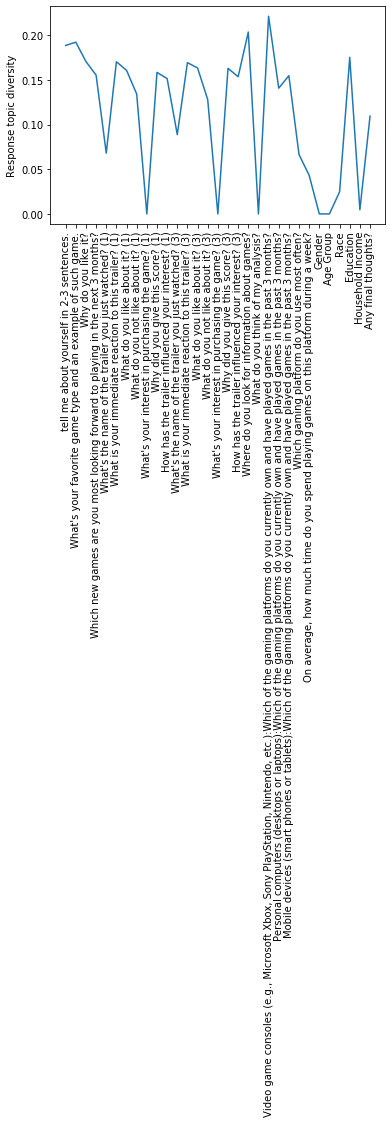

In [10]:
responseAvgDiversity = main(True,'test-set/gamer.csv')

In [11]:
responseAvgDiversity

defaultdict(int,
            {'Age Group': 0.0,
             'Any final thoughts?': 0.10937587459371395,
             'Education': 0.17516511709284527,
             'Gender': 4.133283210756073e-08,
             'Household Income': 0.004649583360462117,
             'How has the trailer influenced your interest? (1)': 0.1514161566340074,
             'How has the trailer influenced your interest? (3)': 0.15344876044345646,
             'Mobile devices (smart phones or tablets):Which of the gaming platforms do you currently own and have played games in the past 3 months?': 0.1546117570884081,
             'On average, how much time do you spend playing games on this platform during a week?': 0.043146806422771806,
             'Personal computers (desktops or laptops):Which of the gaming platforms do you currently own and have played games in the past 3 months?': 0.14066002991654902,
             'Race': 0.024775529141892478,
             'Video game consoles (e.g., Microsoft Xbox, Sony P

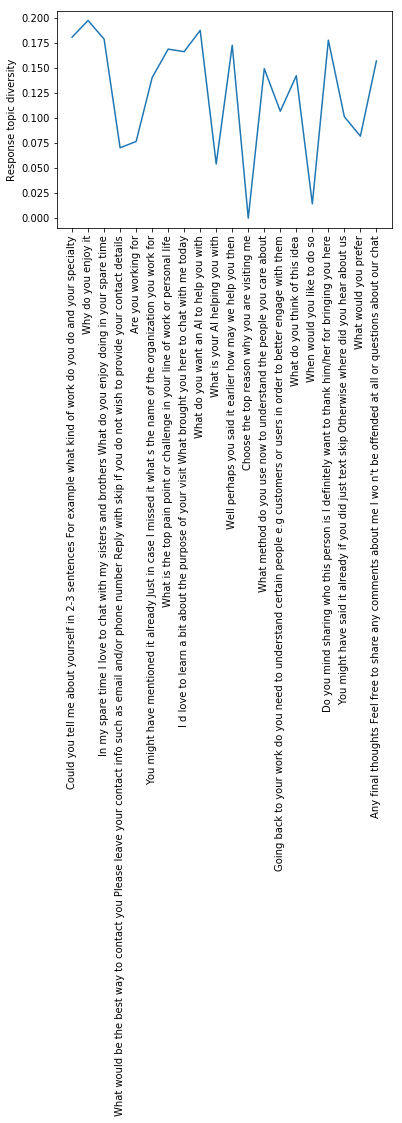

In [111]:
#if input is transcripts
responseAvgDiversity = main(False,None,'test-set/welcome-transcripts/*.txt','test-set/welcome.edn')

In [113]:
responseAvgDiversity

defaultdict(int,
            {'Could you tell me about yourself in 2-3 sentences For example what kind of work do you do and your specialty': 0.18071760413974164,
             'In my spare time I love to chat with my sisters and brothers What do you enjoy doing in your spare time': 0.1788267912053679,
             'What would be the best way to contact you Please leave your contact info such as email and/or phone number Reply with skip if you do not wish to provide your contact details': 0.07030942822264502,
             'You might have mentioned it already Just in case I missed it what s the name of the organization you work for': 0.1402996344281134,
             'starting': 0.03807537175042567,
             'Why do you enjoy it': 0.19738151679566096,
             'Are you working for': 0.07653357116898467,
             'What is the top pain point or challenge in your line of work or personal life': 0.16880056928272,
             'I d love to learn a bit about the purpose of your visi